In [252]:
from Loader_17 import DAVIS_Rawset, normalize
from dift.models.dift_adm import ADMFeaturizer
from deform_video import DAVIS_withPointSet, VideoInferer, DAVIS_withPointRandom
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn.functional as F
from einops import rearrange
import gc
import torch.nn as nn
import torchvision.transforms as transforms
import json
from PIL import Image
from polygon import SoftPolygon
from deform_model import get_batch_average_bou_iou

In [225]:
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()

In [2]:
train_raw_set = DAVIS_Rawset(is_train=True)
val_raw_set = DAVIS_Rawset(is_train=False)

In [253]:
val_infer_set = DAVIS_withPointRandom(
    val_raw_set,
    is_train=False,
    point_num=64,
)

In [10]:
train_set = DAVIS_withPointSet(train_raw_set, is_train=True)

In [42]:
featup = torch.hub.load(
    "mhamilton723/FeatUp",
    "dino16",
    use_norm=True,
).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [123]:
gc.collect()
torch.cuda.empty_cache()

tensor([0., 1.], device='cuda:0')


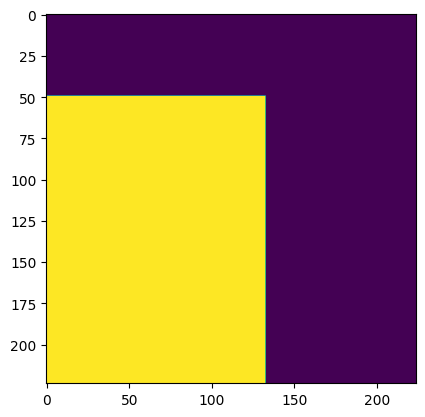

In [158]:
# def restrict_neighborhood(h, w, size_neighborhood, x, y):
#     # We restrict the set of source nodes considered to a spatial neighborhood of the query node (i.e. ``local attention'')
#     mask = torch.zeros(h, w)
#     for p in range(2 * size_neighborhood + 1):
#         for q in range(2 * size_neighborhood + 1):
#             if y - size_neighborhood + p < 0 or y - size_neighborhood + p >= h:
#                 continue
#             if x - size_neighborhood + q < 0 or x - size_neighborhood + q >= w:
#                 continue
#             mask[y - size_neighborhood + p, x - size_neighborhood + q] = 1

#     return mask


def restrict_neighborhood(h, w, size_neighborhood, x, y):
    # We restrict the set of source nodes considered to a spatial neighborhood of the query node (i.e. ``local attention'')
    # write a faster version of the above function
    mask = torch.zeros(h, w)
    y_start = max(0, y - size_neighborhood)
    y_end = min(h, y + size_neighborhood + 1)
    x_start = max(0, x - size_neighborhood)
    x_end = min(w, x + size_neighborhood + 1)
    mask[y_start:y_end, x_start:x_end] = 1
    # mask = mask * (mask == 1)

    return mask


mask = restrict_neighborhood(224, 224, 100, 32, 150).cuda()
print(mask.unique())
plt.imshow(mask.cpu().numpy())

In [170]:
def find_closest_point(target_feats: torch.Tensor, source_feats: torch.Tensor, source_point: torch.tensor, offset: int = 0, size_neighborhood: int = 5):
    source_point = source_point.long()
    
    source_point_feat = source_feats[:, source_point[1], source_point[0]]
    target_vec = rearrange(target_feats, 'c h w -> (h w) c')
    source_vec = rearrange(source_point_feat, 'c -> () c')
    # compute the cosine similarity between the source point feature and all the target features
    similarity = F.cosine_similarity(target_vec, source_vec, dim=1)
    # find the index of the most similar target feature
    similarity = rearrange(similarity, '(h w) -> h w', h=target_feats.shape[1], w=target_feats.shape[2])
    attn_mask = restrict_neighborhood(target_feats.shape[1], target_feats.shape[2], size_neighborhood, source_point[0], source_point[1])
    similarity = similarity * attn_mask.cuda()
    target_point = torch.argmax(similarity)
    # unravel the index to get the target point coordinates
    target_point = torch.tensor(np.unravel_index(target_point.detach().cpu().numpy(), similarity.shape))
    target_point = target_point.flip(0)
    target_point[0] += offset
    return target_point

In [314]:
video_idx = 0
frame_source_idx = 0
frame_target_idx = 15
pointnum_idx = 2
neighor_size = 56

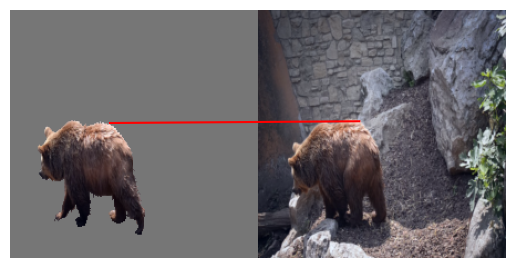

In [320]:
source_img_tensor, source_mask, source_points_set = train_set.raw_data_set[video_idx][
    frame_source_idx
]
target_img_tensor, target_mask, target_points_set = train_set.raw_data_set[video_idx][
    frame_target_idx
]
source_img_tensor *= source_mask
source_img = normalize(source_img_tensor).permute(1, 2, 0).numpy()
target_img = normalize(target_img_tensor).permute(1, 2, 0).numpy()
total_img = np.concatenate([source_img, target_img], axis=1)
plt.imshow(total_img)
source_points = source_points_set[pointnum_idx].clamp(0, 223).numpy()
point_colors = ["r", "g", "b", "y", "m", "c"]
color_array = np.array([point_colors[i % len(point_colors)] for i in range(source_points.shape[0])])
# plt.scatter(source_points[:, 0], source_points[:, 1], c=color_array, s=5)
source_feats = featup(source_img_tensor.unsqueeze(0).cuda()).squeeze(0)
target_feats = featup(target_img_tensor.unsqueeze(0).cuda()).squeeze(0)
point_idx = 0
source_point = source_points[point_idx]
# plt.scatter(source_point[0], source_point[1], c='r', s=5)
source_feat = source_feats[:, source_point[1].astype(int), source_point[0].astype(int)]
img_offset = source_img.shape[1]
closest_point = find_closest_point(target_feats, source_feats, torch.tensor(source_point), img_offset, neighor_size)
# plt.scatter(closest_point[1], closest_point[0], c='b', s=5)
plt.plot([source_point[0], closest_point[0]], [source_point[1], closest_point[1]], c='r')

plt.axis("off")
plt.show()

In [239]:
video_idx = 0
frame_source_idx = 0
frame_target_idx = 15
pointnum_idx = 2
neighor_size = 56

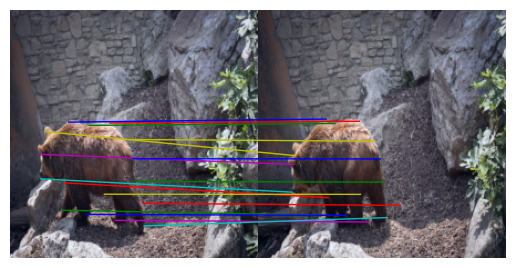

In [240]:
source_img_tensor, source_mask, source_points_set = train_set.raw_data_set[video_idx][
    frame_source_idx
]
target_img_tensor, target_mask, target_points_set = train_set.raw_data_set[video_idx][
    frame_target_idx
]
source_img = normalize(source_img_tensor).permute(1, 2, 0).numpy()
target_img = normalize(target_img_tensor).permute(1, 2, 0).numpy()
total_img = np.concatenate([source_img, target_img], axis=1)
source_points = source_points_set[pointnum_idx].clamp(0, 223).numpy()
point_colors = ["r", "g", "b", "y", "m", "c"]
color_array = np.array([point_colors[i % len(point_colors)] for i in range(source_points.shape[0])])
source_feats = featup(source_img_tensor.unsqueeze(0).cuda()).squeeze(0)
target_feats = featup(target_img_tensor.unsqueeze(0).cuda()).squeeze(0)
img_offset = source_img.shape[1]
target_points = []
for i, point_idx in enumerate(range(source_points.shape[0])):
    source_point = source_points[point_idx]
    source_feat = source_feats[:, source_point[1].astype(int), source_point[0].astype(int)]
    closest_point = find_closest_point(target_feats, source_feats, torch.tensor(source_point), img_offset, neighor_size)
    target_points.append(closest_point)
    plt.plot([source_point[0], closest_point[0]], [source_point[1], closest_point[1]], c=color_array[i], linewidth=1)

plt.imshow(total_img)
plt.axis("off")
plt.show()

In [241]:
target_mask.shape

torch.Size([224, 224])

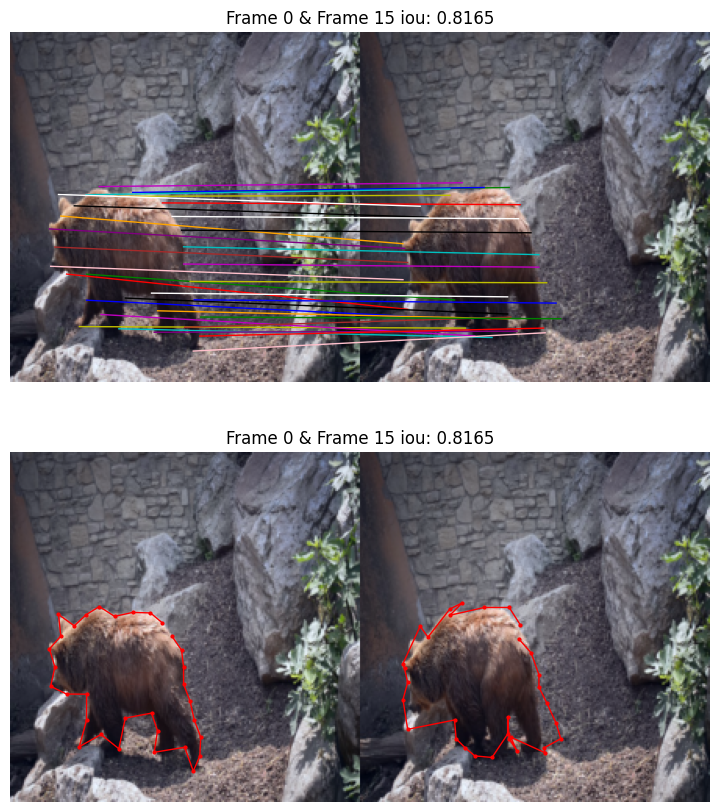

tensor(0.8165, device='cuda:0')

In [246]:
def plot_correspondence(
    source_img: torch.Tensor,
    target_img: torch.Tensor,
    target_mask: torch.Tensor,
    model: nn.Module,
    source_points: torch.Tensor,
    neighor_size: int = 56,
    title: str = "Frame 0 & Frame 15",
    figure_size: tuple = (10, 10),
):
    color_array = np.array(
        ["r", "g", "b", "y", "m", "c", "k", "w", "orange", "purple", "brown", "pink"]
    )
    color_array = np.array([color_array[i % len(color_array)] for i in range(source_points.shape[0])])
    plt.figure(figsize=figure_size)
    plt.subplot(2, 1, 1)
    source_feats = model(source_img.unsqueeze(0).cuda()).squeeze(0)
    target_feats = model(target_img.unsqueeze(0).cuda()).squeeze(0)
    img_offset = source_img.shape[1]
    target_points = []
    for i, point_idx in enumerate(range(source_points.shape[0])):
        source_point = source_points[point_idx]
        closest_point = find_closest_point(
            target_feats, source_feats, source_point, img_offset, neighor_size
        )
        target_points.append(closest_point)
        plt.plot(
            [source_point[0], closest_point[0]],
            [source_point[1], closest_point[1]],
            c=color_array[i],
            linewidth=1,
        )
    target_points = torch.stack(target_points)
    source_img = normalize(source_img).permute(1, 2, 0).numpy()
    target_img = normalize(target_img).permute(1, 2, 0).numpy()
    total_img = np.concatenate([source_img, target_img], axis=1)

    raw_target_points = target_points.clone().float()
    raw_target_points[:, 0] -= source_img.shape[1]
    iou = get_batch_average_bou_iou(raw_target_points.unsqueeze(0).cuda(), target_mask.unsqueeze(0).cuda(), gt_rasterizer)

    plt.imshow(total_img)
    plt.title(title + f" iou: {iou.item():.4f}")
    plt.axis("off")
    plt.subplot(2, 1, 2)
    plt.imshow(total_img)
    plt.axis("off")
    plt.plot(source_points[:, 0], source_points[:, 1], "-o", markersize=2, linewidth=1, c="r")
    plt.plot(target_points[:, 0], target_points[:, 1], "-o", markersize=2, linewidth=1, c="r")
    plt.title(title + f" iou: {iou.item():.4f}")
    plt.show()

    # print(f"iou: {iou.item()}")
    return iou
    


plot_correspondence(
    source_img_tensor,
    target_img_tensor,
    target_mask,
    featup,
    source_points_set[pointnum_idx],
    neighor_size,
    f"Frame {frame_source_idx} & Frame {frame_target_idx}",
)

In [ ]:
def plot_video_examples(
    video_idx: int,
    dataset: DAVIS_withPointSet,
    model: nn.Module,
    frame_idx_0: int,
    frame_idx_1: int,
    pointnum_idx: int,
    neighor_size: int = 56,
    figsize: tuple = (10, 10),
    maskout_source: bool = False,
):
    source_img_tensor, source_mask, source_points_set = dataset.raw_data_set[video_idx][
        frame_idx_0
    ]
    target_img_tensor, target_mask, target_points_set = dataset.raw_data_set[video_idx][
        frame_idx_1
    ]
    if maskout_source:
        source_img_tensor *= source_mask
    return plot_correspondence(
        source_img_tensor,
        target_img_tensor,
        target_mask,
        model,
        source_points_set[pointnum_idx],
        neighor_size,
        f"Frame {frame_idx_0} & Frame {frame_idx_1}",
        figure_size=figsize,
    )
video_idx = 1
neighor_size = 14
pointnum_idx = 3
plot_video_examples(video_idx, train_set, featup, 0, 5, pointnum_idx, neighor_size, maskout_source=True)
plot_video_examples(video_idx, train_set, featup, 0, 10, pointnum_idx, neighor_size, maskout_source=True)
plot_video_examples(video_idx, train_set, featup, 0, 15, pointnum_idx, neighor_size, maskout_source=True)

In [ ]:
video_idx_list = [0, 5, 15, 20, 25]
average_iou_5 = 0
average_iou_10 = 0
average_iou_15 = 0
for video_idx in video_idx_list:
    average_iou_5 += plot_video_examples(video_idx, train_set, featup, 0, 5, pointnum_idx, neighor_size, maskout_source=True)
    average_iou_10 += plot_video_examples(video_idx, train_set, featup, 0, 10, pointnum_idx, neighor_size, maskout_source=True)
    average_iou_15 += plot_video_examples(video_idx, train_set, featup, 0, 15, pointnum_idx, neighor_size, maskout_source=True)
average_iou_5 /= len(video_idx_list)
average_iou_10 /= len(video_idx_list)
average_iou_15 /= len(video_idx_list)
print(f"average_iou_5: {average_iou_5.item():.4f}")
print(f"average_iou_10: {average_iou_10.item():.4f}")
print(f"average_iou_15: {average_iou_15.item():.4f}")

In [327]:
class Featup_wrapper(nn.Module):
    def __init__(self, model: nn.Module, neighor_size: int = 56, mask_pre_frame: bool = False):
        super().__init__()
        self.model = model
        self.neighor_size = neighor_size
        self.mask_pre_frame = mask_pre_frame
        

    def forward(
        self,
        fir_img: torch.Tensor,
        fir_bou: torch.Tensor,
        pre_img: torch.Tensor,
        pre_bou: torch.Tensor,
        pre_sgm: torch.Tensor,
        cur_img: torch.Tensor,
    ):
        pre_img_feats = self.model(pre_img).squeeze(0)
        cur_img_feats = self.model(cur_img).squeeze(0)
        cur_points = []
        if self.mask_pre_frame:
            pre_img = pre_img * pre_sgm
        pre_bou = pre_bou.squeeze(0).clamp(0, 223).float()
        for i in range(pre_bou.shape[0]):
            pre_point = pre_bou[i]
            cur_point = find_closest_point(
                cur_img_feats,
                pre_img_feats,
                pre_point,
                0,
                self.neighor_size,
            )
            cur_points.append(cur_point)
        cur_points = torch.stack(cur_points).to(pre_bou.device)
        cur_points = cur_points.unsqueeze(0)
        return cur_points.float()

        

In [254]:
val_inferer = VideoInferer(val_infer_set, gt_rasterizer)

In [328]:
featup_wrapper = Featup_wrapper(featup, neighor_size, mask_pre_frame=True).cuda()

In [277]:
val_inferer.infer_all_videos(featup_wrapper, use_tqdm=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [13:35<00:00, 14.30s/it]


In [278]:
val_inferer.compute_all_videos_iou()

0.22113969449529464

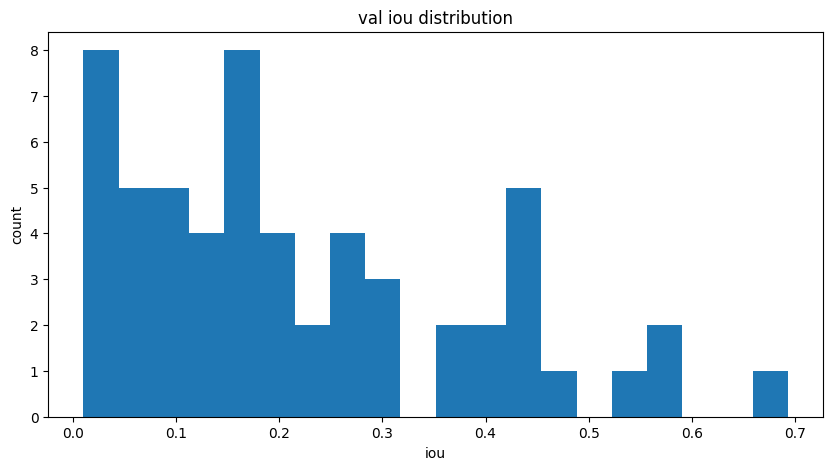

In [280]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 9, 10, 18, 24, 13, 41, 46, 50, 54, 39]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

In [35]:
amd_featurizer = ADMFeaturizer()

/work3/s232248/VOS/DAVIS/dift/models/dift_adm.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cpu"))


In [281]:
amd_transform = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

In [298]:
class AMD_Featup(nn.Module):
    def __init__(self, t=51, up_ft_index=7, ensemble_size=4, output_size=224):
        super().__init__()
        self.t = t
        self.up_ft_index = up_ft_index
        self.ensemble_size = ensemble_size
        self.amd_featurizer = ADMFeaturizer()
        self.amd_transform = transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        )
        self.output_size = output_size

    def forward(self, img: torch.Tensor):
        img = img.squeeze(0)
        img = self.amd_transform(img)
        feats = self.amd_featurizer.forward(
            img,
            self.t,
            self.up_ft_index,
            self.ensemble_size,
        )
        # upsample the feature map to the output size
        feats = F.interpolate(feats, size=(self.output_size, self.output_size), mode="bilinear")

        return feats

In [295]:
target_img_tensor.shape

torch.Size([3, 224, 224])

In [299]:
amd_featup = AMD_Featup().cuda()

In [300]:
amd_featup(target_img_tensor).shape

torch.Size([1, 512, 224, 224])

In [ ]:
video_idx_list = [0, 5, 15, 20, 25]
average_iou_5 = 0
average_iou_10 = 0
average_iou_15 = 0
neighor_size = 14
for video_idx in video_idx_list:
    average_iou_5 += plot_video_examples(video_idx, train_set, amd_featup, 0, 5, pointnum_idx, neighor_size, maskout_source=True)
    average_iou_10 += plot_video_examples(video_idx, train_set, amd_featup, 0, 10, pointnum_idx, neighor_size, maskout_source=True)
    average_iou_15 += plot_video_examples(video_idx, train_set, amd_featup, 0, 15, pointnum_idx, neighor_size, maskout_source=True)
average_iou_5 /= len(video_idx_list)
average_iou_10 /= len(video_idx_list)
average_iou_15 /= len(video_idx_list)
print(f"average_iou_5: {average_iou_5.item():.4f}")
print(f"average_iou_10: {average_iou_10.item():.4f}")
print(f"average_iou_15: {average_iou_15.item():.4f}")

In [329]:
amd_featup_wrapper = Featup_wrapper(amd_featup, neighor_size, mask_pre_frame=True).cuda()

In [304]:
amd_val_inferer = VideoInferer(val_infer_set, gt_rasterizer)

In [330]:
amd_val_inferer.infer_all_videos(amd_featup_wrapper, use_tqdm=True)

  0%|                                                                                                            | 0/57 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [28:33<00:00, 30.07s/it]


In [331]:
amd_val_inferer.compute_all_videos_iou()

0.27415446928179177

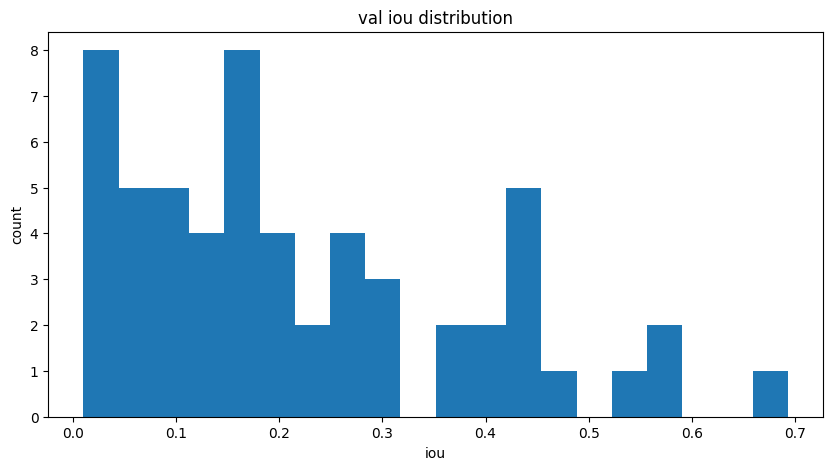

In [332]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 9, 10, 18, 24, 13, 41, 46, 50, 54, 39]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

In [301]:
gc.collect()

27

In [223]:
!env | grep CUDA_VISIBLE_DEVICES

CUDA_VISIBLE_DEVICES=2
CUDA_VISIBLE_DEVICES1=1,2,3,0


In [217]:
!nvidia-smi

Tue Nov  5 17:41:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   56C    P0            230W /  300W |   31344MiB /  32768MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----